In [1]:
%load_ext jupyter_black
import torch
import torch.optim as optim
import torch.nn as nn
from optimizers.lsgd import LSGD
from optimizers.lrmsprop import LRMSprop
from optimizers.ladam import LAdam
from optimizers.ladadelta import LAdadelta
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import tqdm
import math

plt.style.use(["grid", "science", "no-latex"])

seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Sanity check with a toy problem

In [2]:
r"""The following code is a toy classification problem from the pytorch documentation we use 
to perform a quick sanity check of our Langevin optimization algorithms.

    https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
"""

import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(
    root="./CIFAR", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root="./CIFAR", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

We First verify the sanity of our Langevin optimizers without any noise and see how they compare to their ```torch.optim``` counterparts.

In [5]:
def gradient_step(model, inputs, targets, optimizer, loss_fn):
    optimizer.zero_grad()

    outputs = model(inputs)
    loss = loss_fn(outputs, targets)
    loss.backward()
    optimizer.step()

    return loss.item()

In [6]:
net_sgd = Net()
net_lsgd = Net()
net_rmsprop = Net()
net_lrmsprop = Net()
net_adam = Net()
net_ladam = Net()
net_adadelta = Net()
net_ladadelta = Net()

criterion = nn.CrossEntropyLoss()
sgd = optim.SGD(net_sgd.parameters(), lr=0.001, momentum=0)
lsgd = LSGD(net_lsgd.parameters(), lr=0.001, sigma=0.0, momentum=0)
rmsprop = optim.RMSprop(net_rmsprop.parameters(), lr=0.001)
lrmsprop = LRMSprop(net_lrmsprop.parameters(), lr=0.001, sigma=0.0)
adam = optim.Adam(net_adam.parameters(), lr=0.001)
ladam = LAdam(net_ladam.parameters(), lr=0.001, sigma=0.0)
adadelta = optim.Adadelta(net_adadelta.parameters(), lr=1.0)
ladadelta = LAdadelta(net_ladadelta.parameters(), lr=1.0, sigma=0.0)

In [7]:
sgd_losses = []
lsgd_losses = []
rmsprop_losses = []
lrmsprop_losses = []
adam_losses = []
ladam_losses = []
adadelta_losses = []
ladadelta_losses = []

for epoch in range(3):  # loop over the dataset multiple times
    sgd_running_loss = 0.0
    lsgd_running_loss = 0.0
    rmsprop_running_loss = 0.0
    lrmsprop_running_loss = 0.0
    adam_running_loss = 0.0
    ladam_running_loss = 0.0
    adadelta_running_loss = 0.0
    ladadelta_running_loss = 0.0
    with tqdm.tqdm(
        total=len(trainloader), position=0, leave=True, desc=f"epoch {epoch}"
    ) as progress_bar:
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            sgd_running_loss += gradient_step(net_sgd, inputs, labels, sgd, criterion)
            lsgd_running_loss += gradient_step(
                net_lsgd, inputs, labels, lsgd, criterion
            )
            rmsprop_running_loss += gradient_step(
                net_rmsprop, inputs, labels, rmsprop, criterion
            )
            lrmsprop_running_loss += gradient_step(
                net_lrmsprop, inputs, labels, lrmsprop, criterion
            )
            adam_running_loss += gradient_step(
                net_adam, inputs, labels, adam, criterion
            )
            ladam_running_loss += gradient_step(
                net_ladam, inputs, labels, ladam, criterion
            )
            adadelta_running_loss += gradient_step(
                net_adadelta, inputs, labels, adadelta, criterion
            )
            ladadelta_running_loss += gradient_step(
                net_ladadelta, inputs, labels, ladadelta, criterion
            )

            if i % 2000 == 1999:  # print every 2000 mini-batches
                progress_bar.set_description(
                    f"epoch {epoch}, SGD: {sgd_running_loss/2000:.2f}, LSGD: {lsgd_running_loss/2000:.2f}, RMS: {rmsprop_running_loss/2000:.2f}, LRMS: {lrmsprop_running_loss/2000:.2f}, ADAM: {adam_running_loss/2000:.2f}, LADAM: {ladam_running_loss/2000:.2f}, ADADEL: {adadelta_running_loss/2000:.2f}, LADADEL: {ladadelta_running_loss/2000:.2f}"
                )

                sgd_losses.append(sgd_running_loss / 2000)
                sgd_running_loss = 0.0
                lsgd_losses.append(lsgd_running_loss / 2000)
                lsgd_running_loss = 0.0
                rmsprop_losses.append(rmsprop_running_loss / 2000)
                rmsprop_running_loss = 0.0
                lrmsprop_losses.append(lrmsprop_running_loss / 2000)
                lrmsprop_running_loss = 0.0
                adam_losses.append(adam_running_loss / 2000)
                adam_running_loss = 0.0
                ladam_losses.append(ladam_running_loss / 2000)
                ladam_running_loss = 0.0
                adadelta_losses.append(adadelta_running_loss / 2000)
                adadelta_running_loss = 0.0
                ladadelta_losses.append(ladadelta_running_loss / 2000)
                ladadelta_running_loss = 0.0

            progress_bar.update(1)

print("Finished Training")

epoch 0, SGD: 2.03, LSGD: 2.14, RMS: 1.37, LRMS: 1.41, ADAM: 1.37, LADAM: 1.37, ADADEL: 1.61, LADADEL: 1.61: 100%|██████████| 12500/12500 [02:49<00:00, 73.81it/s]
epoch 1, SGD: 1.73, LSGD: 1.76, RMS: 1.25, LRMS: 1.27, ADAM: 1.23, LADAM: 1.24, ADADEL: 1.64, LADADEL: 1.63: 100%|██████████| 12500/12500 [02:54<00:00, 71.44it/s]
epoch 2, SGD: 1.58, LSGD: 1.61, RMS: 1.21, LRMS: 1.23, ADAM: 1.16, LADAM: 1.18, ADADEL: 1.62, LADADEL: 1.70: 100%|██████████| 12500/12500 [02:57<00:00, 70.26it/s]

Finished Training


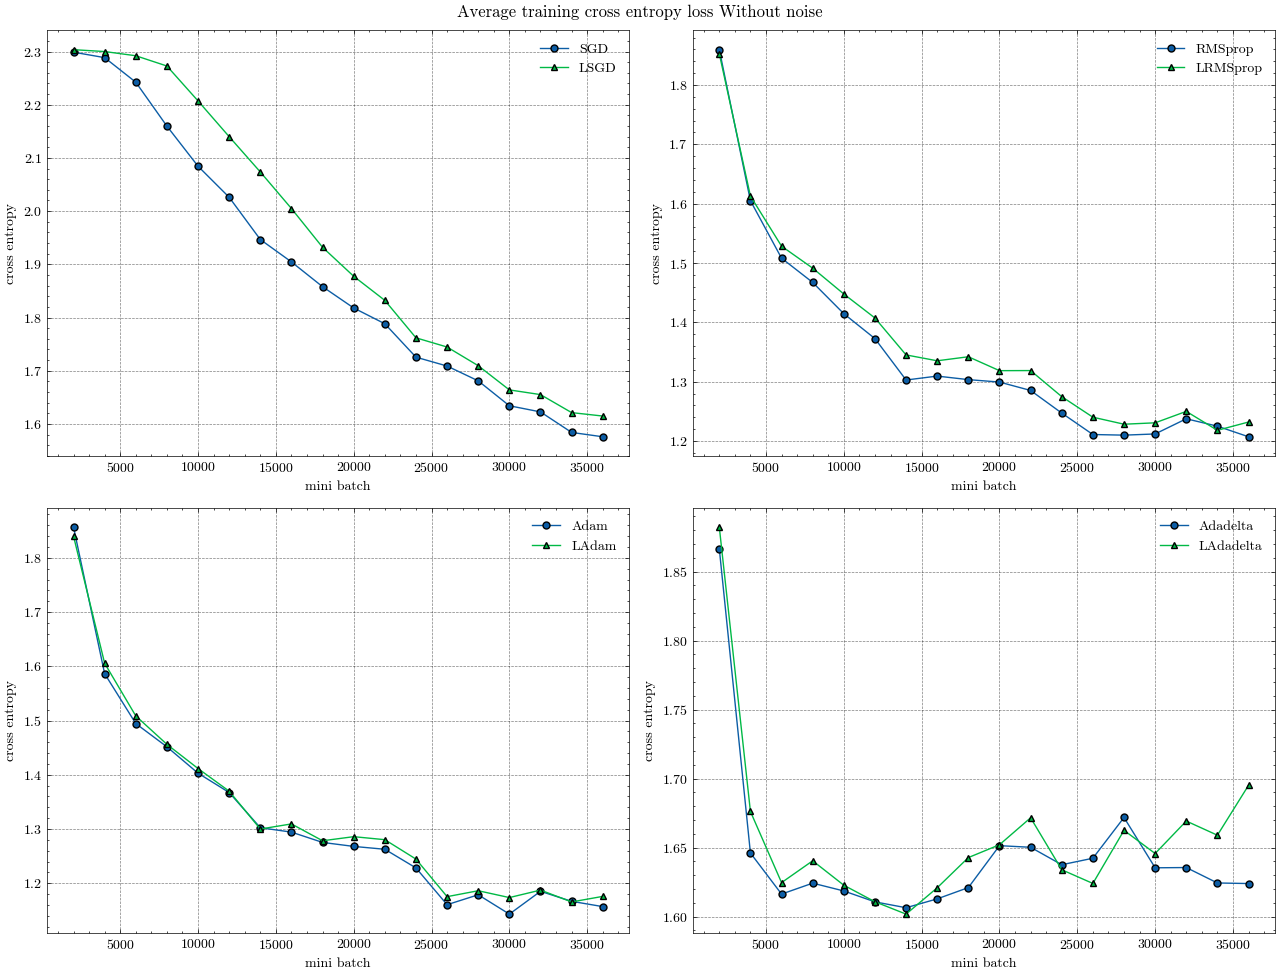

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(13, 10))

# SGD plots
axs[0][0].plot(
    2000 * (1 + np.arange(len(sgd_losses))),
    sgd_losses,
    label="SGD",
    marker="o",
    mec="k",
    ms=5,
)
axs[0][0].plot(
    2000 * (1 + np.arange(len(lsgd_losses))),
    lsgd_losses,
    label="LSGD",
    marker="^",
    mec="k",
    ms=5,
)
axs[0][0].legend()
axs[0][0].set_xlabel("mini batch")
axs[0][0].set_ylabel("cross entropy")

# RMSprop plots
axs[0][1].plot(
    2000 * (1 + np.arange(len(rmsprop_losses))),
    rmsprop_losses,
    label="RMSprop",
    marker="o",
    mec="k",
    ms=5,
)
axs[0][1].plot(
    2000 * (1 + np.arange(len(lrmsprop_losses))),
    lrmsprop_losses,
    label="LRMSprop",
    marker="^",
    mec="k",
    ms=5,
)
axs[0][1].legend()
axs[0][1].set_xlabel("mini batch")
axs[0][1].set_ylabel("cross entropy")

# Adam plots
axs[1][0].plot(
    2000 * (1 + np.arange(len(adam_losses))),
    adam_losses,
    label="Adam",
    marker="o",
    mec="k",
    ms=5,
)
axs[1][0].plot(
    2000 * (1 + np.arange(len(ladam_losses))),
    ladam_losses,
    label="LAdam",
    marker="^",
    mec="k",
    ms=5,
)
axs[1][0].legend()
axs[1][0].set_xlabel("mini batch")
axs[1][0].set_ylabel("cross entropy")

# Adadelta plots
axs[1][1].plot(
    2000 * (1 + np.arange(len(adadelta_losses))),
    adadelta_losses,
    label="Adadelta",
    marker="o",
    mec="k",
    ms=5,
)
axs[1][1].plot(
    2000 * (1 + np.arange(len(ladadelta_losses))),
    ladadelta_losses,
    label="LAdadelta",
    marker="^",
    mec="k",
    ms=5,
)
axs[1][1].legend()
axs[1][1].set_xlabel("mini batch")
axs[1][1].set_ylabel("cross entropy")


fig.suptitle("Average training cross entropy loss Without noise")
fig.tight_layout()
plt.show()
plt.close()

Our optimizers seem to behave in the same way as their ```torch.optim```counterparts as expected. We see a slight different in their losses but it is due to the randomness in the train dataloader. We now attempt adding a bit of noise to the algorithms.

In [9]:
net_sgd = Net()
net_lsgd = Net()
net_rmsprop = Net()
net_lrmsprop = Net()
net_adam = Net()
net_ladam = Net()
net_adadelta = Net()
net_ladadelta = Net()

criterion = nn.CrossEntropyLoss()
sgd = optim.SGD(net_sgd.parameters(), lr=0.001, momentum=0)
lsgd = LSGD(net_lsgd.parameters(), lr=0.001, sigma=0.01, momentum=0)
rmsprop = optim.RMSprop(net_rmsprop.parameters(), lr=0.001)
lrmsprop = LRMSprop(net_lrmsprop.parameters(), lr=0.001, sigma=0.0001)
adam = optim.Adam(net_adam.parameters(), lr=0.001)
ladam = LAdam(net_ladam.parameters(), lr=0.001, sigma=0.0001)
adadelta = optim.Adadelta(net_adadelta.parameters(), lr=0.001)
ladadelta = LAdadelta(net_ladadelta.parameters(), lr=0.001, sigma=0.0001)

In [10]:
sgd_losses = []
lsgd_losses = []
rmsprop_losses = []
lrmsprop_losses = []
adam_losses = []
ladam_losses = []
adadelta_losses = []
ladadelta_losses = []

for epoch in range(3):  # loop over the dataset multiple times
    sgd_running_loss = 0.0
    lsgd_running_loss = 0.0
    rmsprop_running_loss = 0.0
    lrmsprop_running_loss = 0.0
    adam_running_loss = 0.0
    ladam_running_loss = 0.0
    adadelta_running_loss = 0.0
    ladadelta_running_loss = 0.0
    with tqdm.tqdm(
        total=len(trainloader), position=0, leave=True, desc=f"epoch {epoch}"
    ) as progress_bar:
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            sgd_running_loss += gradient_step(net_sgd, inputs, labels, sgd, criterion)
            lsgd_running_loss += gradient_step(
                net_lsgd, inputs, labels, lsgd, criterion
            )
            rmsprop_running_loss += gradient_step(
                net_rmsprop, inputs, labels, rmsprop, criterion
            )
            lrmsprop_running_loss += gradient_step(
                net_lrmsprop, inputs, labels, lrmsprop, criterion
            )
            adam_running_loss += gradient_step(
                net_adam, inputs, labels, adam, criterion
            )
            ladam_running_loss += gradient_step(
                net_ladam, inputs, labels, ladam, criterion
            )
            adadelta_running_loss += gradient_step(
                net_adadelta, inputs, labels, adadelta, criterion
            )
            ladadelta_running_loss += gradient_step(
                net_ladadelta, inputs, labels, ladadelta, criterion
            )

            if i % 2000 == 1999:  # print every 2000 mini-batches
                progress_bar.set_description(
                    f"epoch {epoch}, SGD: {sgd_running_loss/2000:.2f}, LSGD: {lsgd_running_loss/2000:.2f}, RMS: {rmsprop_running_loss/2000:.2f}, LRMS: {lrmsprop_running_loss/2000:.2f}, ADAM: {adam_running_loss/2000:.2f}, LADAM: {ladam_running_loss/2000:.2f}, ADADEL: {adadelta_running_loss/2000:.2f}, LADADEL: {ladadelta_running_loss/2000:.2f}"
                )

                sgd_losses.append(sgd_running_loss / 2000)
                sgd_running_loss = 0.0
                lsgd_losses.append(lsgd_running_loss / 2000)
                lsgd_running_loss = 0.0
                rmsprop_losses.append(rmsprop_running_loss / 2000)
                rmsprop_running_loss = 0.0
                lrmsprop_losses.append(lrmsprop_running_loss / 2000)
                lrmsprop_running_loss = 0.0
                adam_losses.append(adam_running_loss / 2000)
                adam_running_loss = 0.0
                ladam_losses.append(ladam_running_loss / 2000)
                ladam_running_loss = 0.0
                adadelta_losses.append(adadelta_running_loss / 2000)
                adadelta_running_loss = 0.0
                ladadelta_losses.append(ladadelta_running_loss / 2000)
                ladadelta_running_loss = 0.0

            progress_bar.update(1)

print("Finished Training")

epoch 0, SGD: 1.99, LSGD: 2.04, RMS: 1.39, LRMS: 1.40, ADAM: 1.38, LADAM: 1.42, ADADEL: 2.29, LADADEL: 2.30: 100%|██████████| 12500/12500 [02:48<00:00, 74.36it/s]
epoch 1, SGD: 1.77, LSGD: 1.67, RMS: 1.30, LRMS: 1.37, ADAM: 1.26, LADAM: 1.29, ADADEL: 2.25, LADADEL: 2.22: 100%|██████████| 12500/12500 [02:49<00:00, 73.67it/s]
epoch 2, SGD: 1.61, LSGD: 1.55, RMS: 1.25, LRMS: 1.37, ADAM: 1.17, LADAM: 1.19, ADADEL: 2.18, LADADEL: 2.11: 100%|██████████| 12500/12500 [02:45<00:00, 75.39it/s]

Finished Training


In [63]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(13, 10))

# SGD plots
axs[0][0].plot(
    2000 * (1 + np.arange(len(sgd_losses))),
    sgd_losses,
    label="SGD",
    marker="o",
    mec="k",
    ms=5,
)
axs[0][0].plot(
    2000 * (1 + np.arange(len(lsgd_losses))),
    lsgd_losses,
    label="LSGD",
    marker="^",
    mec="k",
    ms=5,
)
axs[0][0].legend()
axs[0][0].set_xlabel("mini batch")
axs[0][0].set_ylabel("cross entropy")

# RMSprop plots
axs[0][1].plot(
    2000 * (1 + np.arange(len(rmsprop_losses))),
    rmsprop_losses,
    label="RMSprop",
    marker="o",
    mec="k",
    ms=5,
)
axs[0][1].plot(
    2000 * (1 + np.arange(len(lrmsprop_losses))),
    lrmsprop_losses,
    label="LRMSprop",
    marker="^",
    mec="k",
    ms=5,
)
axs[0][1].legend()
axs[0][1].set_xlabel("mini batch")
axs[0][1].set_ylabel("cross entropy")

# Adam plots
axs[1][0].plot(
    2000 * (1 + np.arange(len(adam_losses))),
    adam_losses,
    label="Adam",
    marker="o",
    mec="k",
    ms=5,
)
axs[1][0].plot(
    2000 * (1 + np.arange(len(ladam_losses))),
    ladam_losses,
    label="LAdam",
    marker="^",
    mec="k",
    ms=5,
)
axs[1][0].legend()
axs[1][0].set_xlabel("mini batch")
axs[1][0].set_ylabel("cross entropy")

# Adadelta plots
axs[1][1].plot(
    2000 * (1 + np.arange(len(adadelta_losses))),
    adadelta_losses,
    label="Adadelta",
    marker="o",
    mec="k",
    ms=5,
)
axs[1][1].plot(
    2000 * (1 + np.arange(len(ladadelta_losses))),
    ladadelta_losses,
    label="LAdadelta",
    marker="^",
    mec="k",
    ms=5,
)
axs[1][1].legend()
axs[1][1].set_xlabel("mini batch")
axs[1][1].set_ylabel("cross entropy")


fig.suptitle("Average training cross entropy loss With noise")
fig.tight_layout()
plt.show()
plt.close()

NameError: name 'plt' is not defined

### I. Fishing quotas:

In [2]:
from diffusion.fishing import Fishing
from training.train import train

In [3]:
def plot_langevin_loss(
    test_loss,
    test_ci,
    test_loss_langevin,
    test_ci_langevin,
    test_loss_llangevin=None,
    test_ci_llangevin=None,
    ll=10,
    name="SGD",
):
    fig = plt.figure(figsize=(7, 5))
    plt.plot(
        np.arange(len(test_loss)), test_loss, marker="o", mec="k", ms=5, label=name
    )
    plt.fill_between(
        np.arange(len(test_loss)),
        np.array(test_loss) - np.array(test_ci),
        np.array(test_loss) + np.array(test_ci),
        alpha=0.2,
    )
    plt.plot(
        np.arange(len(test_loss_langevin)),
        test_loss_langevin,
        marker="o",
        mec="k",
        ms=5,
        label=f"L{name}",
    )
    plt.fill_between(
        np.arange(len(test_loss_langevin)),
        np.array(test_loss_langevin) - np.array(test_ci_langevin),
        np.array(test_loss_langevin) + np.array(test_ci_langevin),
        alpha=0.2,
    )
    if test_loss_llangevin:
        plt.plot(
            np.arange(len(test_loss_llangevin)),
            test_loss_llangevin,
            marker="o",
            mec="k",
            ms=5,
            label=f"LL{name}-{ll}%",
        )
        plt.fill_between(
            np.arange(len(test_loss_llangevin)),
            np.array(test_loss_llangevin) - np.array(test_ci_llangevin),
            np.array(test_loss_llangevin) + np.array(test_ci_llangevin),
            alpha=0.2,
        )

    plt.xlabel("Epochs")
    plt.ylabel(r"$J(u_\theta)$")

    plt.legend()
    plt.show()
    plt.close()

In [4]:
train_batch = 512
test_batch = 512
train_size = 5
test_size = 25
epochs = 50
init_lr = 2e-3
target_lr = 2e-4
modify_until = 40
factor = math.pow(target_lr / init_lr, 1 / modify_until)
control = dict(
    input_dim=6, output_dim=5, hidden_dim=32, depth=2, out_transform=nn.Sigmoid()
)
kappa = torch.Tensor(
    [
        [1.2, -0.1, 0.0, 0.0, -0.1],
        [0.2, 1.2, 0.0, 0.0, -0.1],
        [0.0, 0.2, 1.2, -0.1, 0.0],
        [0.0, 0.0, 0.1, 1.2, 0.0],
        [0.1, 0.1, 0.0, 0.0, 1.2],
    ]
)

In [5]:
ocp = Fishing(
    N_euler=50,
    kappa=kappa,
)
ocp.set_control(control, multiple_controls=False)
adam = optim.Adam(ocp.control.parameters(), lr=2e-3)
scheduler = optim.lr_scheduler.StepLR(adam, step_size=modify_until, gamma=factor)
epochs = 50

train_loss_adam, test_loss_adam, test_ci_adam = train(
    ocp, adam, scheduler, "Adam", epochs, train_size, test_size, train_batch, test_batch
)

Fishing: Epoch 49, Adam, lr=0.00189, train=0.297, test=0.297: 100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


In [6]:
ocp = Fishing(
    N_euler=50,
    kappa=kappa,
)
ocp.set_control(control, multiple_controls=False)
ladam = LAdam(ocp.control.parameters(), lr=2e-3, sigma=1e-3)
scheduler = optim.lr_scheduler.StepLR(ladam, step_size=modify_until, gamma=factor)
epochs = 50

train_loss_ladam, test_loss_ladam, test_ci_ladam = train(
    ocp,
    ladam,
    scheduler,
    "LAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Fishing: Epoch 49, LAdam, lr=0.00189, train=0.294, test=0.286: 100%|██████████| 50/50 [00:13<00:00,  3.83it/s]


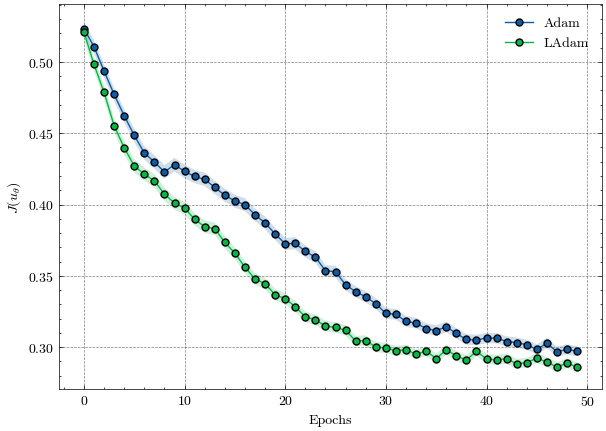

In [7]:
plot_langevin_loss(
    test_loss_adam, test_ci_adam, test_loss_ladam, test_ci_ladam, name="Adam"
)

In [8]:
ocp = Fishing(
    N_euler=50,
    kappa=kappa,
)
ocp.set_control(control, multiple_controls=False)
adadelta = optim.Adadelta(ocp.control.parameters(), lr=5e-1)
scheduler = optim.lr_scheduler.StepLR(adadelta, step_size=modify_until, gamma=factor)
epochs = 50

train_loss_adadelta, test_loss_adadelta, test_ci_adadelta = train(
    ocp,
    adadelta,
    scheduler,
    "Adadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Training Fishing with Adadelta:   0%|          | 0/50 [00:00<?, ?it/s]

Fishing: Epoch 49, Adadelta, lr=0.47203, train=0.423, test=0.418: 100%|██████████| 50/50 [00:13<00:00,  3.76it/s]


In [9]:
ocp = Fishing(
    N_euler=50,
    kappa=kappa,
)
ocp.set_control(control, multiple_controls=False)
ladadelta = LAdadelta(ocp.control.parameters(), lr=5e-1, sigma=1e-2)
scheduler = optim.lr_scheduler.StepLR(ladadelta, step_size=modify_until, gamma=factor)
epochs = 50

train_loss_ladadelta, test_loss_ladadelta, test_ci_ladadelta = train(
    ocp,
    ladadelta,
    scheduler,
    "Adadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Training Fishing with Adadelta:   0%|          | 0/50 [00:00<?, ?it/s]

Fishing: Epoch 49, Adadelta, lr=0.47203, train=0.406, test=0.403: 100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


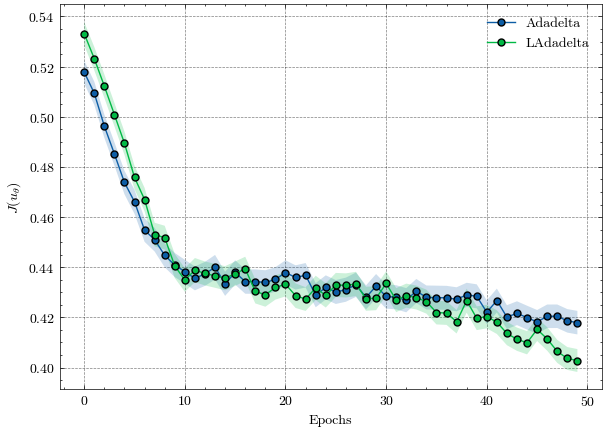

In [10]:
plot_langevin_loss(
    test_loss_adadelta,
    test_ci_adadelta,
    test_loss_ladadelta,
    test_ci_ladadelta,
    name="Adadelta",
)

In [11]:
ocp = Fishing(
    N_euler=50,
    kappa=kappa,
)
ocp.set_control(control, multiple_controls=False)
rmsprop = optim.RMSprop(ocp.control.parameters(), lr=2e-3)
scheduler = optim.lr_scheduler.StepLR(rmsprop, step_size=modify_until, gamma=factor)
epochs = 50

train_loss_rmsprop, test_loss_rmsprop, test_ci_rmsprop = train(
    ocp,
    rmsprop,
    scheduler,
    "RMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Fishing: Epoch 49, RMSprop, lr=0.00189, train=0.291, test=0.286: 100%|██████████| 50/50 [00:14<00:00,  3.50it/s]


In [12]:
ocp = Fishing(
    N_euler=50,
    kappa=kappa,
)
ocp.set_control(control, multiple_controls=False)
lrmsprop = LRMSprop(ocp.control.parameters(), lr=2e-3, sigma=5e-3)
scheduler = optim.lr_scheduler.StepLR(lrmsprop, step_size=modify_until, gamma=factor)
epochs = 50

train_loss_lrmsprop, test_loss_lrmsprop, test_ci_lrmsprop = train(
    ocp,
    lrmsprop,
    scheduler,
    "LRMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Fishing: Epoch 49, LRMSprop, lr=0.00189, train=0.580, test=0.570: 100%|██████████| 50/50 [00:14<00:00,  3.56it/s]


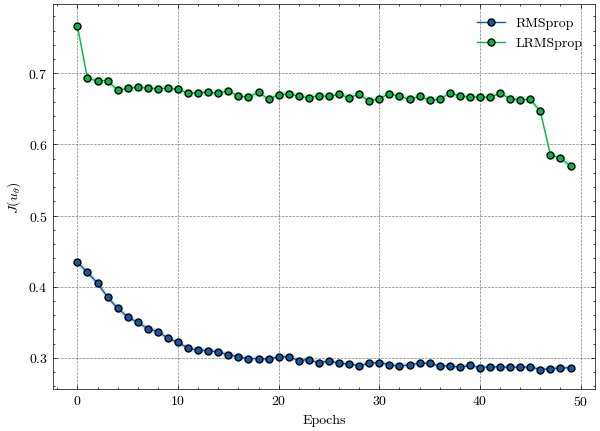

In [13]:
plot_langevin_loss(
    test_loss_rmsprop,
    test_ci_rmsprop,
    test_loss_lrmsprop,
    test_ci_lrmsprop,
    name="RMSprop",
)

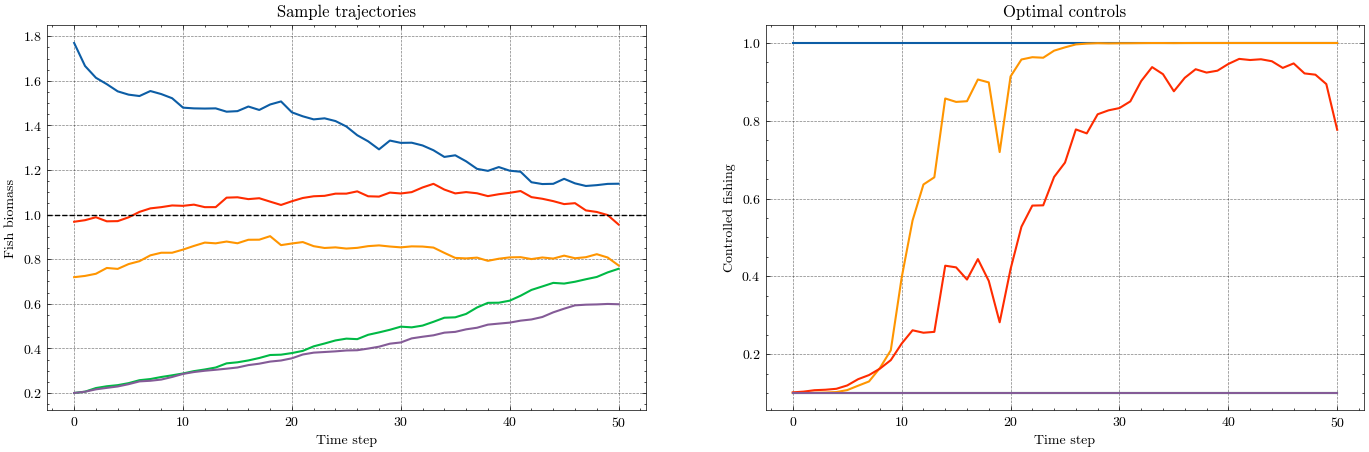

In [14]:
X, u = ocp.sample_traj(1)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(17, 5))

for k in range(X.shape[2]):
    ax1.plot(X[:, :, k].flatten().detach().numpy(), lw=1.5)
    ax2.plot(u[:, :, k].flatten().detach().numpy(), lw=1.5)
ax1.axhline(1, linestyle="--", color="k")
ax1.set_title("Sample trajectories")
ax1.set_xlabel("Time step")
ax1.set_ylabel("Fish biomass")
ax2.set_title("Optimal controls")
ax2.set_xlabel("Time step")
ax2.set_ylabel("Controlled fishing")
plt.show()
plt.close()

In [15]:
control_config = dict(
    input_dim=5, output_dim=5, hidden_dim=32, depth=2, out_transform=nn.Sigmoid()
)

In [16]:
ocp = Fishing(
    N_euler=10,
    kappa=kappa,
)
ocp.set_control(control_config, multiple_controls=True)
adam = [optim.Adam(control.parameters(), lr=2e-3) for control in ocp.control]
scheduler = [
    optim.lr_scheduler.StepLR(opt, step_size=modify_until, gamma=factor) for opt in adam
]
epochs = 50

train_loss_adam, test_loss_adam, test_ci_adam = train(
    ocp, adam, scheduler, "Adam", epochs, train_size, test_size, train_batch, test_batch
)

Fishing: Epoch 49, Adam, lr=0.00189, train=0.265, test=0.266: 100%|██████████| 50/50 [00:03<00:00, 16.22it/s]


In [17]:
ocp = Fishing(
    N_euler=10,
    kappa=kappa,
)
ocp.set_control(control_config, multiple_controls=True)
ladam = [LAdam(control.parameters(), lr=2e-3, sigma=1e-3) for control in ocp.control]
scheduler = [
    optim.lr_scheduler.StepLR(opt, step_size=modify_until, gamma=factor)
    for opt in ladam
]
epochs = 50

train_loss_ladam, test_loss_ladam, test_ci_ladam = train(
    ocp,
    ladam,
    scheduler,
    "LAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Fishing: Epoch 49, LAdam, lr=0.00189, train=0.289, test=0.299: 100%|██████████| 50/50 [00:03<00:00, 15.91it/s]


In [18]:
ocp = Fishing(
    N_euler=10,
    kappa=kappa,
)
ocp.set_control(control_config, multiple_controls=True)
ll = 10  # Langevin Layer percentage
lladam = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        lladam.append(LAdam(control.parameters(), lr=2e-3, sigma=2e-3))
    else:
        lladam.append(optim.Adam(control.parameters(), lr=2e-3))
scheduler = [
    optim.lr_scheduler.StepLR(opt, step_size=modify_until, gamma=factor)
    for opt in lladam
]
epochs = 50

train_loss_lladam, test_loss_lladam, test_ci_lladam = train(
    ocp,
    lladam,
    scheduler,
    "LLAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Fishing: Epoch 49, LLAdam, lr=0.00189, train=0.278, test=0.271: 100%|██████████| 50/50 [00:02<00:00, 16.75it/s]


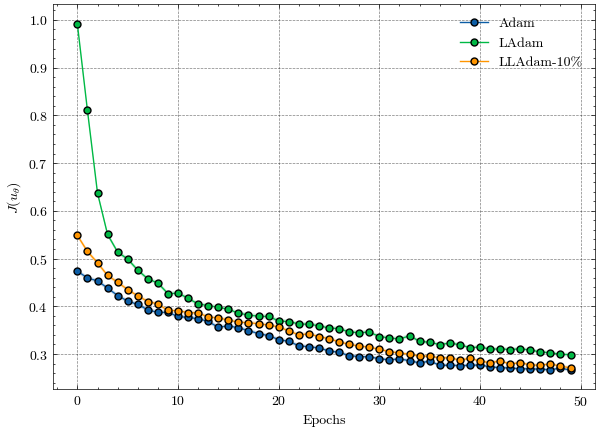

In [19]:
plot_langevin_loss(
    test_loss_adam,
    test_ci_adam,
    test_loss_ladam,
    test_ci_ladam,
    test_loss_lladam,
    test_ci_lladam,
    ll=ll,
    name="Adam",
)

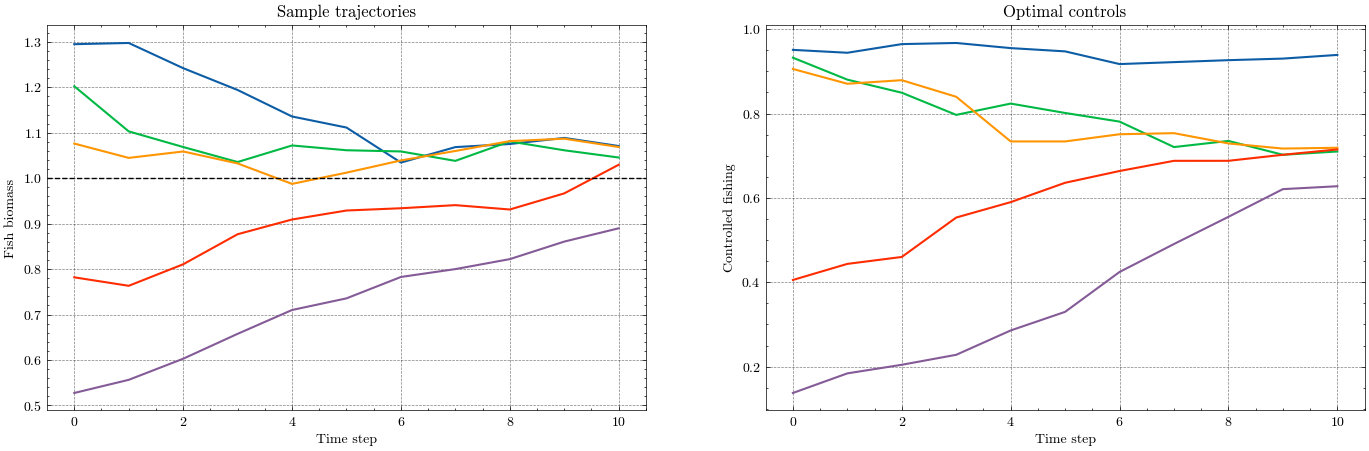

In [20]:
X, u = ocp.sample_traj(1)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(17, 5))

for k in range(X.shape[2]):
    ax1.plot(X[:, :, k].flatten().detach().numpy(), lw=1.5)
    ax2.plot(u[:, :, k].flatten().detach().numpy(), lw=1.5)
ax1.axhline(1, linestyle="--", color="k")
ax1.set_title("Sample trajectories")
ax1.set_xlabel("Time step")
ax1.set_ylabel("Fish biomass")
ax2.set_title("Optimal controls")
ax2.set_xlabel("Time step")
ax2.set_ylabel("Controlled fishing")
plt.show()
plt.close()

In [21]:
ocp = Fishing(
    N_euler=10,
    kappa=kappa,
)
ocp.set_control(control_config, multiple_controls=True)
adadelta = [optim.Adadelta(control.parameters(), lr=5e-1) for control in ocp.control]
scheduler = [
    optim.lr_scheduler.StepLR(opt, step_size=modify_until, gamma=factor) for opt in adam
]
epochs = 50

train_loss_adadelta, test_loss_adadelta, test_ci_adadelta = train(
    ocp,
    adadelta,
    scheduler,
    "Adadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Training Fishing with Adadelta:   0%|          | 0/50 [00:00<?, ?it/s]/Users/saad/anaconda3/envs/stats/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Fishing: Epoch 49, Adadelta, lr=0.00178, train=0.401, test=0.398: 100%|██████████| 50/50 [00:02<00:00, 16.99it/s]


In [22]:
ocp = Fishing(
    N_euler=10,
    kappa=kappa,
)
ocp.set_control(control_config, multiple_controls=True)
ladadelta = [
    LAdadelta(control.parameters(), lr=5e-1, sigma=5e-3) for control in ocp.control
]
scheduler = [
    optim.lr_scheduler.StepLR(opt, step_size=modify_until, gamma=factor) for opt in adam
]
epochs = 50

train_loss_ladadelta, test_loss_ladadelta, test_ci_ladadelta = train(
    ocp,
    ladadelta,
    scheduler,
    "LAdadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Fishing: Epoch 49, LAdadelta, lr=0.00168, train=0.400, test=0.395: 100%|██████████| 50/50 [00:03<00:00, 15.98it/s]


In [23]:
ocp = Fishing(
    N_euler=10,
    kappa=kappa,
)
ocp.set_control(control_config, multiple_controls=True)
ll = 10  # Langevin Layer percentage
lladadelta = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        lladadelta.append(LAdadelta(control.parameters(), lr=5e-1, sigma=5e-3))
    else:
        lladadelta.append(optim.Adadelta(control.parameters(), lr=5e-1))
scheduler = [
    optim.lr_scheduler.StepLR(opt, step_size=modify_until, gamma=factor)
    for opt in lladadelta
]
epochs = 50

train_loss_lladadelta, test_loss_lladadelta, test_ci_lladadelta = train(
    ocp,
    lladadelta,
    scheduler,
    "LLAdadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Fishing: Epoch 49, LLAdadelta, lr=0.47203, train=0.396, test=0.399: 100%|██████████| 50/50 [00:03<00:00, 15.66it/s]


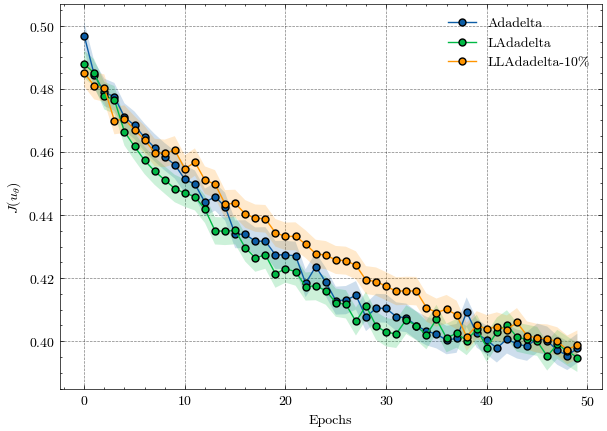

In [24]:
plot_langevin_loss(
    test_loss_adadelta,
    test_ci_adadelta,
    test_loss_ladadelta,
    test_ci_ladadelta,
    test_loss_lladadelta,
    test_ci_lladadelta,
    ll=ll,
    name="Adadelta",
)

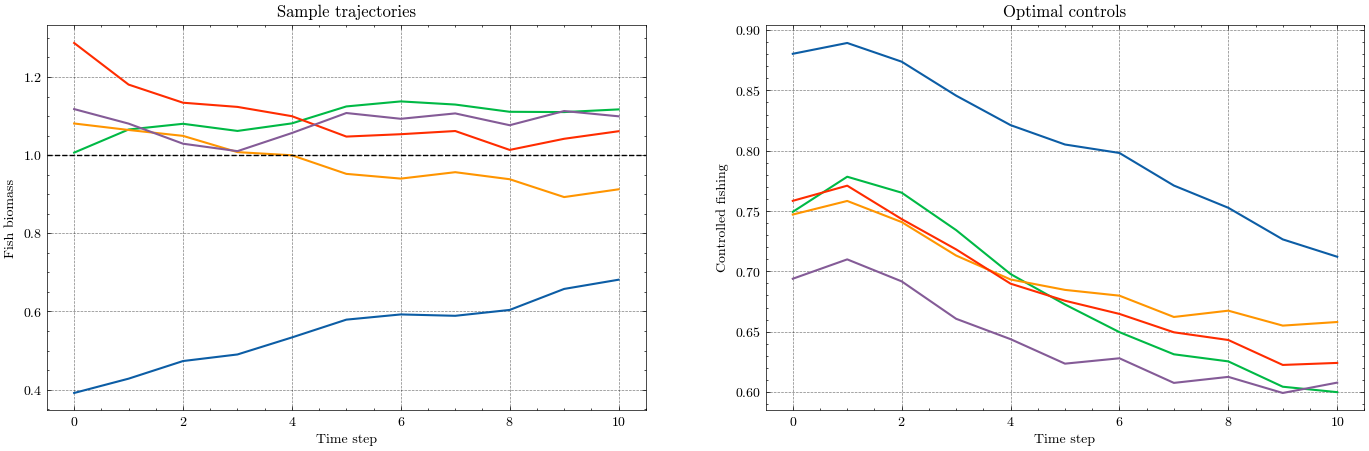

In [25]:
X, u = ocp.sample_traj(1)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(17, 5))

for k in range(X.shape[2]):
    ax1.plot(X[:, :, k].flatten().detach().numpy(), lw=1.5)
    ax2.plot(u[:, :, k].flatten().detach().numpy(), lw=1.5)
ax1.axhline(1, linestyle="--", color="k")
ax1.set_title("Sample trajectories")
ax1.set_xlabel("Time step")
ax1.set_ylabel("Fish biomass")
ax2.set_title("Optimal controls")
ax2.set_xlabel("Time step")
ax2.set_ylabel("Controlled fishing")
plt.show()
plt.close()